# LSTM(Long Short-Term Memory)
- SimpleRNN층은 Dense층과 같이 기능적으로 매우 단순하게 구성되어 있기 때문에 깊이 쌓을수록 학습에 큰 문제가 존재
- "시점이 흐를수록 지속해서 기억하지 못한다" 
    - -> SimpleRNN층에 그래디언트 손실 문제가 존재한다는 것을 의미
- 이를 해결하기 위해 고안된 것 : LSTM(Long Short-Term Memory)
- 1997년 호흐라이터(Hochreiter)와 슈미트후버(Schmidhuber)에 의해 만들어짐

## LSTM을 이용한 로이터 뉴스 카테고리 분류

### 1. 로이터 뉴스 데이타셋 불러오기
#### 1) 로이터 뉴스 데이타셋
- 로이터 뉴스 데이타 사용
- 총 11,258개의 뉴스 기사가 46개 카테고리로 나누어진 대용량 텍스트 데이타
- 케라스의 load_data() 함수를 통해 불러올 수 있음

In [1]:
# 경고(worning) 무시
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.datasets import reuters

num_words = 10000

# num_words=1000 -> 단어의 빈도가 1 ~ 1000에 해당하는 단어만 선택해서 불러오기
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=num_words) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8982,) (8982,)
(2246,) (2246,)


#### 2) 데이터 확인하기

In [6]:
X_train[:1]

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])],
      dtype=object)

In [7]:
y_train[:1]

array([3], dtype=int64)

In [8]:
# 데이터 확인하기
import numpy as np

category = np.max(y_train) + 1

print('카테고리 개수 : ', category )
print('학습용 뉴스 기사 개수 : ', len(x_train))
print('테스트용 뉴스 기사 개수 :', len(x_test))

print('단어가 나온 빈도(tokenizer() 이용하여 작업 완료) : ')
print(X_train[0])

카테고리 개수 :  46
학습용 뉴스 기사 개수 :  8982
테스트용 뉴스 기사 개수 : 2246
단어가 나온 빈도(tokenizer() 이용하여 작업 완료) : 
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


### 2. 데이타 전처리
- 각 기사의 단어 수를 통일 : pad_sequences() 사용
- 기사의 단어수가 500개를 넘으면 500개 단어만 선택하고 나머지 버림
- 500에서 모자랄 때는 0으로 채워서 500개를 만듦

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=500

# 데이타 전처리
pad_x_train = pad_sequences(X_train, maxlen=max_len) # 단어수를 500개로 맞추라는 뜻
pad_x_test = pad_sequences(X_test, maxlen=max_len)

print(len(pad_x_train[0]))
print(len(pad_x_test[0]))

500
500


### 3. 모델 구성하기
- Embedding 층 
    - 데이터 전처리 과정을 통해 입력된 값을 받아 다음 층이 알아들을 수 있는 형태로 변환하는 역할을 함
    - Embedding('불러온 단어의 총 개수', '기사당 단어 수') 형식으로 사용하며, 모델 설정 부분의 맨 처음에 있어야 함<br>
- LSTM 층
    - LSTM은 RNN에서 기억 값에 대한 가중치를 제어함
    - LSTM(기사당 단어 수, 기타 옵션)의 형태로 적용됨
    - LSTM의 활성화 함수로는 tanh를 사용  

In [10]:
# 모듈 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

import tensorflow as tf
import numpy as np

# seed 값 설정
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

# 모델 구성
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 64)) # 입력층
model.add(LSTM(64, return_sequences = True)) # 은닉층
model.add(LSTM(32)) # 은닉층
model.add(Dense(46, activation='softmax')) # 출력층

### 4. 모델  컴파일 설정

In [11]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

### 5. 모델 학습

In [12]:
# 모델 학습
history = model.fit(pad_x_train, y_train, 
                    batch_size=32, 
                    epochs=20, 
                    validation_split = 0.2)

Epoch 1/20
225/225 [==============================] - 67s 283ms/step - loss: 2.5513 - acc: 0.3514 - val_loss: 2.4087 - val_acc: 0.3450
Epoch 2/20
225/225 [==============================] - 58s 259ms/step - loss: 2.4091 - acc: 0.3534 - val_loss: 2.4014 - val_acc: 0.3450
Epoch 3/20
225/225 [==============================] - 61s 270ms/step - loss: 2.1550 - acc: 0.4412 - val_loss: 1.8966 - val_acc: 0.4830
Epoch 4/20
225/225 [==============================] - 68s 303ms/step - loss: 1.7577 - acc: 0.5439 - val_loss: 1.7066 - val_acc: 0.5398
Epoch 5/20
225/225 [==============================] - 68s 303ms/step - loss: 1.6493 - acc: 0.5758 - val_loss: 1.6479 - val_acc: 0.5954
Epoch 6/20
225/225 [==============================] - 68s 303ms/step - loss: 1.5259 - acc: 0.6199 - val_loss: 1.5949 - val_acc: 0.6138
Epoch 7/20
225/225 [==============================] - 68s 303ms/step - loss: 1.3981 - acc: 0.6489 - val_loss: 1.6256 - val_acc: 0.5960
Epoch 8/20
225/225 [==============================] - 6

### 6. 모델 평가

In [13]:
# 모델 평가
model.evaluate(pad_x_test, y_test)

71/71 [==============================] - 6s 89ms/step - loss: 1.7130 - acc: 0.6474


[1.7130438089370728, 0.6473730802536011]

### 7. 학습 과정 그리기

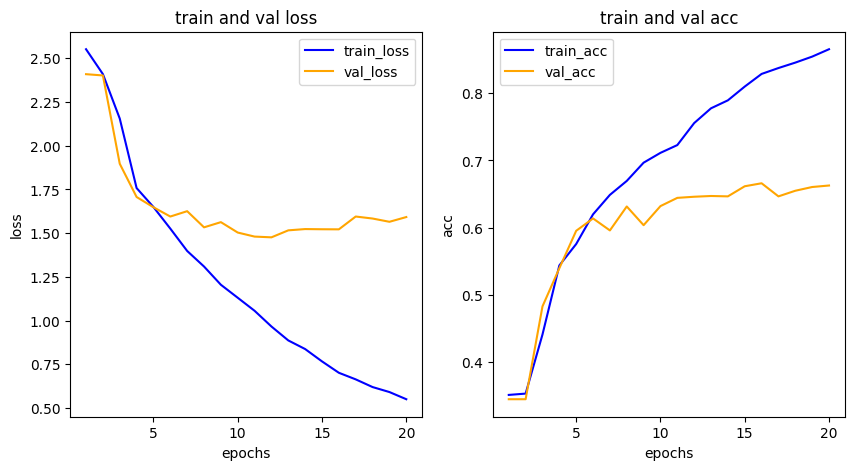

In [14]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

#### 실행 결과 해석) 
- 테스트셋에 대한 정확도가 0.6291을 보이고 있음
- 테스트 오차가 상승하기 전까지의 학습이 과적합 직전의 최적 학습 시간임